## Predicting Power Grid Blackouts in Real-Time Using ML
The Power Grid is going through unprecedented changes, mainly driven by the need for de-carbonisation due to climate change but also due to other technical, economic and social reasons. A significant number of Renewable Energy Sources (such as wind & solar) are being connected to the electricity system, which was not expected by the power system planners/operators. These operational changes can cause unexpected behavior of the dynamics after a disturbance (such as lightning or trees touching lines). 

- An example of how the voltage waveform look after a stable disturbance is as follows. They recover to the previous voltage in an oscillatory manner.

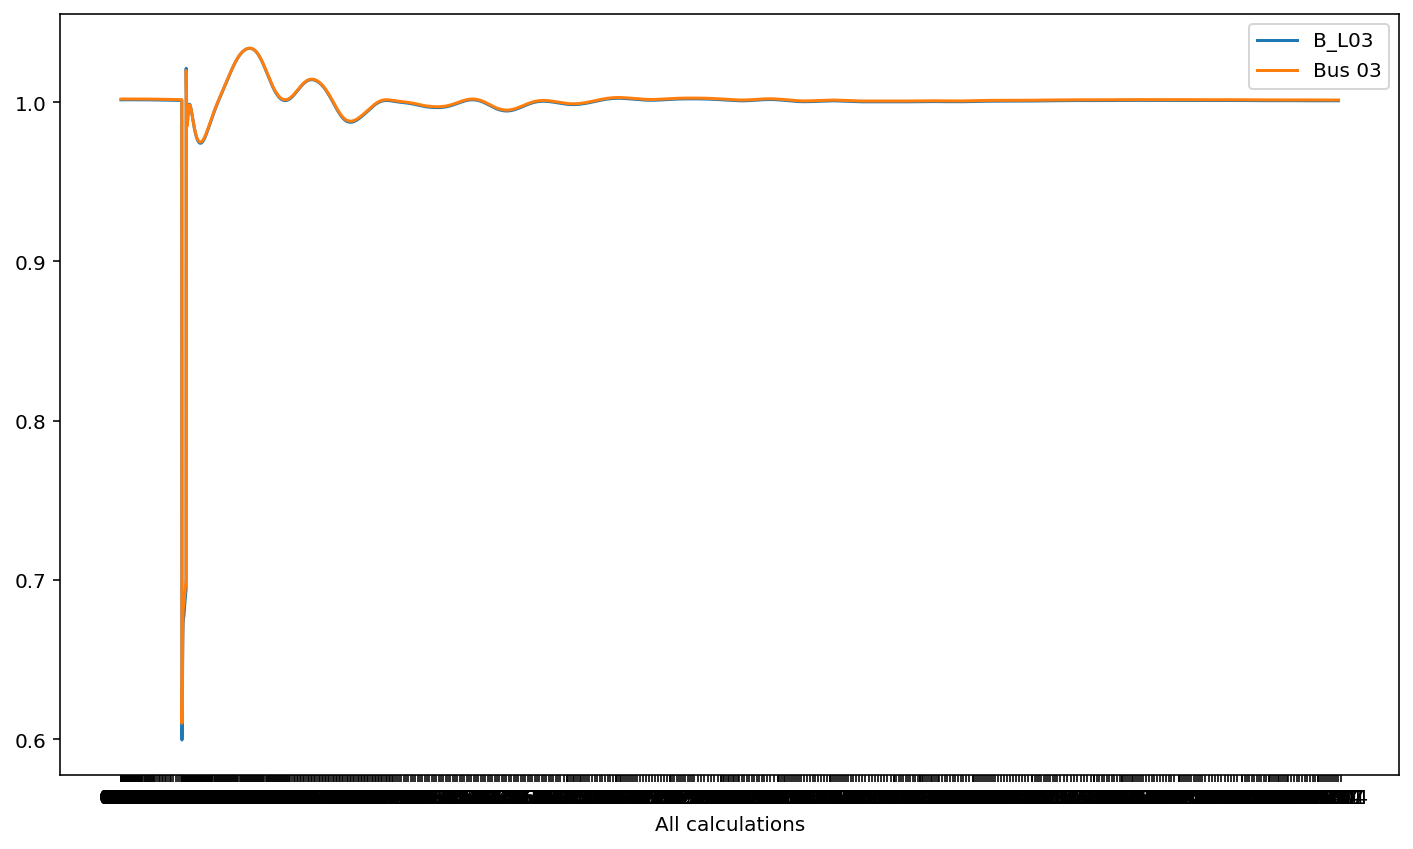

## Cascading in Power Grids
When a component (transmission line/ generator) are disconnected for any reason, the stress on the remaining components increases, leading to a possibility of more components disconnecting eventually leading to a cascading blackout. Two examples are listed below for which more than 1000 MW of power was disconnected after these events. **Nearly a Million customers lost power during these events.**
- The South Australia blackout in Sep 2016 was caused due to wind farm disconnecting after a few transmission lines disconnected, leading to a blackout. The plot of voltages at a few wind plants are shown below. The time from the disturbance to the final instability is less than 2 seconds. (the disturbance was at the first voltage dip) [1]

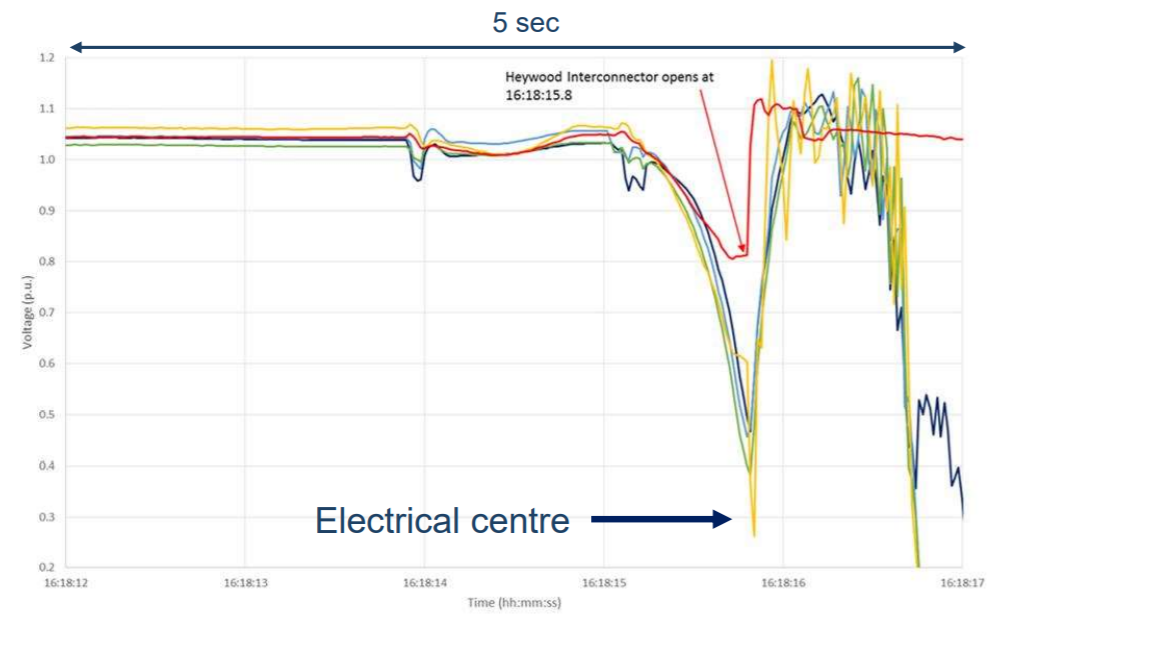

- **The UK blackout in August 2019 was caused due to the wind farms disconnecting after lightning strikes. This led to frequency imbalance that had to be corrected by disconnecting load. [2]** (the plots are not available for this event)

References

[1] Australian Energy Market Operator "BLACK SYSTEM SOUTH AUSTRALIA 28 SEPTEMBER 2016 – FINAL REPORT", [available online]  https://www.aemo.com.au/-/media/Files/Electricity/NEM/Market_Notices_and_Events/Power_System_Incident_Reports/2017/Integrated-Final-Report-SA-Black-System-28-September-2016.pdf

[2] Office of Gas and Electricity Markets Authority (Ofgem) "Technical Report on the events of 9 August 2019", [available online] https://www.ofgem.gov.uk/system/files/docs/2019/09/eso_technical_report_-_final.pdf
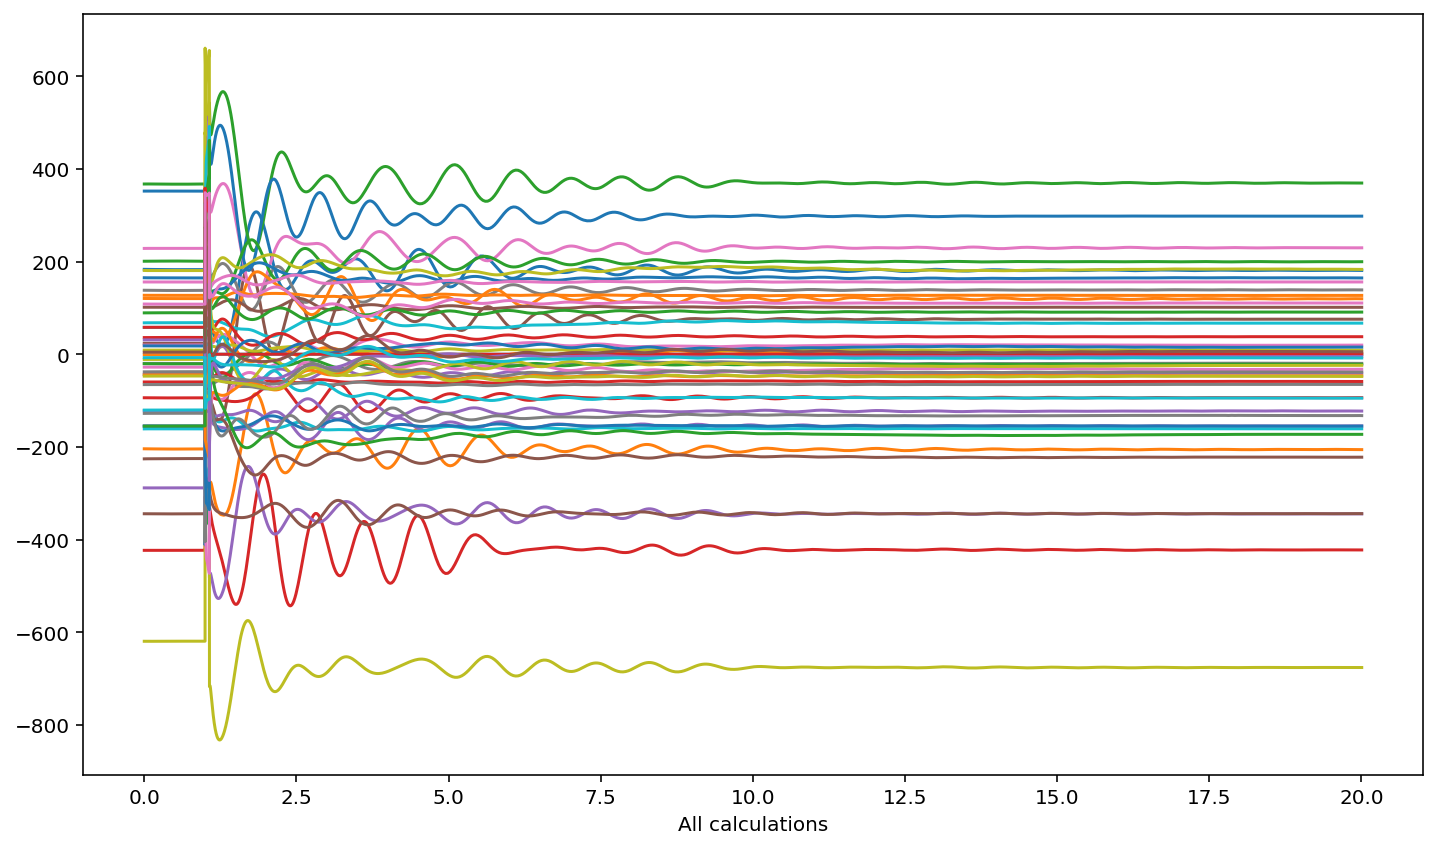

## Need for ML

Electrical power systems are complex non-linear dynamical systems and their dynamic behavior is commonly represented using several hundreds to thousands of differential equations. To answer even simple questions about the grid behavior, simulations up to several tens of seconds need to be performed. This process is computationally intensive since an increasingly high number of simulations need to be executed to account for various operating conditions and disturbances, making it very hard to evaluate system stability close to real time. **Can we train an ML model on offline simulation data to learn the regions of operation that are stable and regions that are unstable ? These models can then be deployed real-time on measurements on the grid.** In the conceptual figure below the prediction window is ~10 sec and we want to classify this as an unstable event.
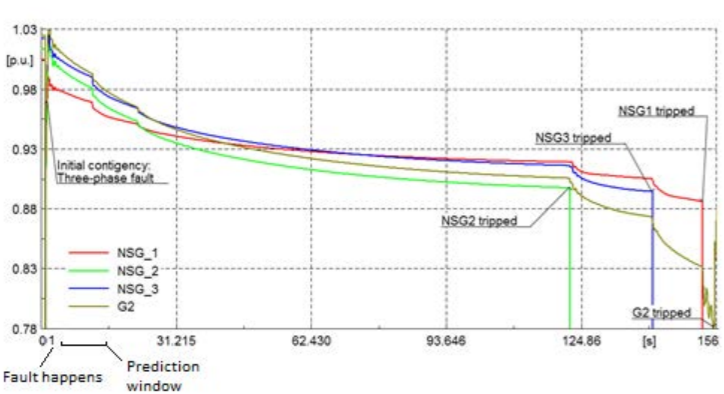

**Questions to Answer**
- Can we identify the components that will be disconnected?
- Can we identify the time when the components will be disconnected?
- Do we need all the data or is a subset of the data sufficient for the prediction? This is important as the measurement devices and their infrastructure is expensive and utilities always want to minimize costs
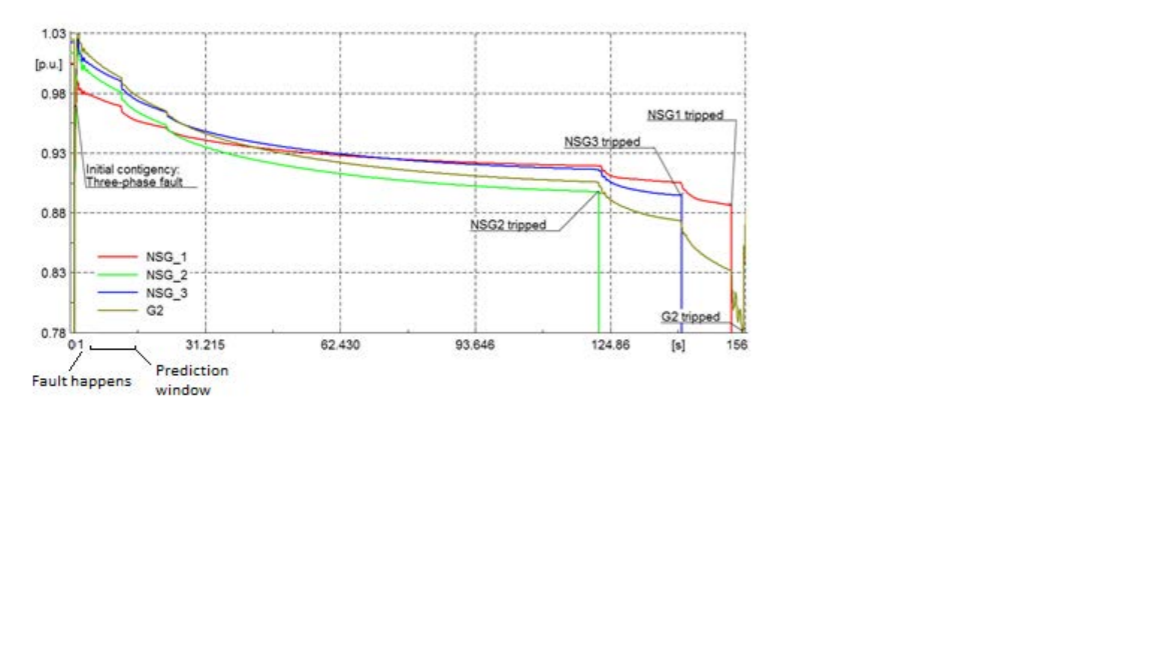

## System Under Study and Dataset Provided
 
- The system topology and physics is that of an IEEE 39 bus power system, a common benchmark model used in the study of power systems, in which 10 generators and 39 "buses" (nodes) are connected by lines.

- This is an extremely complex system which requires 100s to 1000s of differential equations to model accurately. 

- This system has been modified to include the dynamic parameters of the generators. 

- Three of the generators in the topology are wind farms, rather than standard coal/gas generators. 

- As wind farms don't always produce power, the other generators sometimes have to compensate when the power output of the wind farms dips. This makes the system more vulnerable. 

- The dataset consists of 44064 simulations, each corresponding to a unique set of operating conditions. Each simulation is stored in a csv file.

There are 249 features (not including time) and over 3000 timesteps for each simulation, resulting in a large dataset.


<img src="ieee_39_bus_power_system_pres.png" style="max-width:40%">


## Challenges in applying ML 
- measurements are not normalized (show plot?)
- large data sets
- non-uniform columns
- very few samples of a particular cascade 
- unequal time sampling points
- periodic angle data
- Multi-Index ??

## Exploratory Data Analysis

We used the Pandas dataframe data structure to read the data and analyze the data.

Of the datasets we have to analyse, 35,934 are not associated with component failure, 7,131 resulted in failure of at least 1 component, and 999 caused errors and did not produce results.
The mean and standard deviation of the number of failed components (across all failure cases) were found to be 9.701 and 13.708, respectively.

Of the cases with failures, the number of failed components is shown below:

<img src="n_fail.png" style="max-width:40%">

In these cases, failure generally occurred within the first 3s of the simulation. This will inform our model by reducing the dataset to a range in which our predictions will allow a decision maker to act.

<img src="t_first_fail_subsection_l.png" style="max-width:40%">

- **Cascading Failure Analysis:** In cases with multiple failing components, subsequent failures often occurred very soon after th initial failure:

<img src="t_first_to_second_fail.png" style="max-width:40%">

There is a spike of subsequent failures at 0.0s. These are components that failed immediately after an initial failure. Although there are a large number of unique components in the system, we can broadly categorise them as:
 - Generators
 - Non-Sysnchronous Generators (NSGs), which are the 3 contributions to the system from wind turbines
 - Loads

The components that failed immediately after an initial failure were generally 'Load' and the components that failed a long time after the inital failure were generally generators and NSGs.

- **Correlation Analysis:** The minimum correlation of each measurement time series with another measurement for over all scenarios is calculated and the final minimal-correlation matrix is used to cluster the various measurements to identify any redundant measurements. A preliminary result of the dendrogram from the hierarchal clustering of the measurements is shown below.

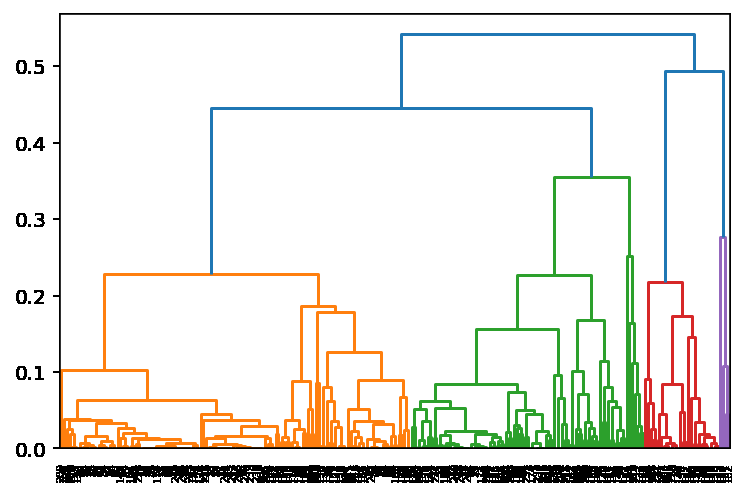 

## Preprocessing steps

One of the first challenges in this study is how to handle correctly the data and put it in a usable format to throw in our model. This preprocessing also needs to account for the specificity of the data and the need of severals algorithms.

- convert all dtypes to float
- ensure all dataframes have similar shape
- normalize the data: the normalize needs to be the same across all dataframes, which makes this step more complex (describe the chosen approach ?)
- interpolation in order to get evenly spaced simulations (each simulation has different sampled timestamps): the best approximation at spike was given using a spline interpolation of first order
- in order to remove uncessary data: keep only data after the disturbance was introduced (around 1.07 seconds)
- the periodicity of angular data from generators can preserved by transforming it to sin and cos components, this may be used depending on the importance of these features
- windowing: perform analytics functions over successive periods in equally spaced time series data

## Dimensionality reduction

- Linear approaches: PCA
- Non-linear approaches: Isomap

Problem: the power grid is a network with multiple components. The dataset features each component as a variable and a single component might have multiple columns associated with it. (Generator 1 Active Power, Generator 1 Reactive Power, etc.)

## Modeling

 - A single layer LSTM model for binary classification
     - Can we predict the first failure before it happens?
     - 100 + 20 simulations with and without failures respectively
     - 80% - 20% train - test set split
     - Data prior to the system disturbance and data after the first failure (*0.5 seconds before the first failure) are excluded from failure data
     - Model input and output formats: (n_batches, n_time_steps, n_features), (n_batches, 1)
     
 - An autoencoder model for anomaly detection
     - Can we predict an upcoming failure by capturing anomalies?
     - Use 100 simulations without any failures to train an autoencoder
     - Input and output formats: (n_batches, n_time_steps, n_features), (n_batches, n_time_steps, n_features)
     - Incentive: non-failure data will be reconstructed with relatively minimal loss, data with an expected failure in the future will have a much higher reconstruction loss. We can threshold the loss value to detect anomalies: 'likely to fail'.

## First results

- LSTM model results on the test set (20 non-fail cases, 4 fail cases)
    - Accuracy on test set: 0.886
    - Precision: 0.83
    - Recall: 0.87
    - F1 Score: 0.85